In [1]:
# this is the wrapper notebook
# 1) it shows how a regression model is created
# 2) how the model input and output and model weights get quantized
# 3) how the model weights and test set are exported as cairo inputs
# 4) how cairo script is invoked
# 5) how cairo proof is generated
# 7) how cairo prediction output is retrieved
# 8) cairo prediction output is dequantized
# 9) cairo prediction and native prediction is compared

In [2]:
import time
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression
from sklearn.model_selection import train_test_split
from concrete.ml.quantization import QuantizedArray
import json
from json import JSONEncoder
import re

/home/mister/micromamba/envs/cairo1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

# Create the training and test set

In [92]:
BITS=8
# pylint: disable=unbalanced-tuple-unpacking
WEIGHTS=5
X, y = make_regression(
    n_samples=200, n_features=WEIGHTS, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
X = X 
y= y 
# pylint: enable=unbalanced-tuple-unpacking

# Split it into train/test and sort the sets for nicer visualization
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#sidx = np.argsort(np.squeeze(x_train))
#x_train = x_train[sidx, :]
#y_train = y_train[sidx]

#sidx = np.argsort(np.squeeze(x_test))
#x_test = x_test[sidx, :]
#y_test = y_test[sidx]

In [93]:
linreg = SklearnLinearRegression()
tic = time.perf_counter()
linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"Classic sklearn fitting {toc - tic:0.4f} seconds")
print(linreg.coef_)

Classic sklearn fitting 0.0056 seconds
[ 1.63586268 11.4331783  67.09072934 19.66672525 65.61296023]


In [94]:
tic = time.perf_counter()
y_pred = linreg.predict(x_test)
toc = time.perf_counter()
time_sklearn_model_predict = toc - tic
print(f"Classic sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")

Classic sklearn model prediction 0.0009 seconds


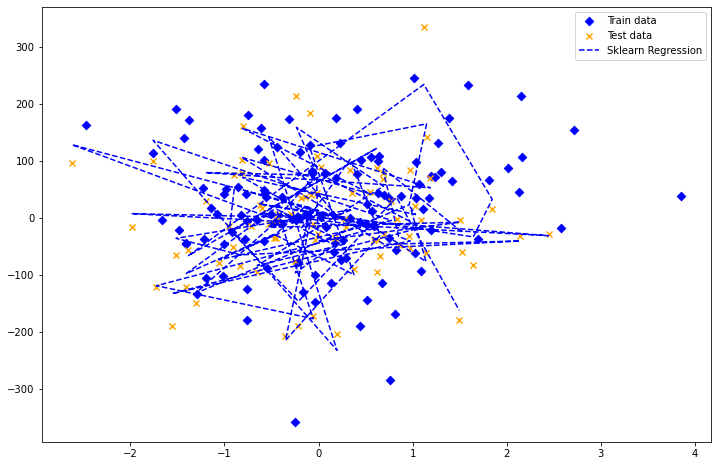

In [95]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(x_train[:,0], y_train, c="blue", marker="D", label="Train data")
ax.scatter(x_test[:,0], y_test, c="orange", marker="x", label="Test data")
ax.plot(x_test[:,0], y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)


#  how the model input and output and model weights get quantized
Open point: How to get the coefficient and intercept quantized? Somehow it should be possible to extract it from concrete ml?

In [96]:
q_X = QuantizedArray(BITS, X)
q_y = QuantizedArray(BITS, y)
# Split it into train/test and sort the sets for nicer visualization
q_x_train, q_x_test, q_y_train, q_y_test = train_test_split(q_X.quant(), q_y.quant(), test_size=0.4, random_state=42)

#q_sidx = np.argsort(np.squeeze(q_x_train))
#q_x_train = q_x_train[sidx, :]
#q_y_train = q_y_train[sidx]#

#q_sidx = np.argsort(np.squeeze(q_x_test))
#q_x_test = q_x_test[q_sidx, :]
#q_y_test = q_y_test[sidx]

In [97]:
linreg_qdata = SklearnLinearRegression()
tic = time.perf_counter()
linreg_qdata.fit(q_x_train, q_y_train)
toc = time.perf_counter()
print(f"Quantized data sklearn fitting {toc - tic:0.4f} seconds")
print(linreg_qdata.coef_)

Quantized data sklearn fitting 0.0040 seconds
[0.0157074  0.11876681 0.68672433 0.20257889 0.67049609]


In [98]:
tic = time.perf_counter()
q_y_pred = linreg_qdata.predict(q_x_test)
toc = time.perf_counter()
time_sklearn_model_predict = toc - tic
print(f"Quantized data sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")

Quantized data sklearn model prediction 0.0056 seconds


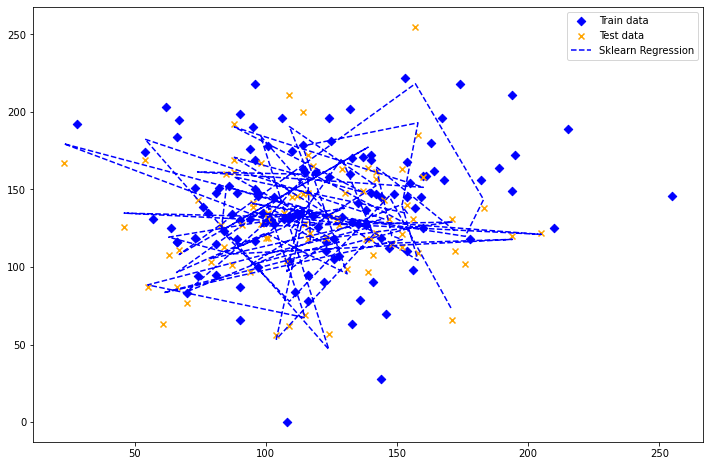

In [99]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(q_x_train[:,0], q_y_train, c="blue", marker="D", label="Train data")
ax.scatter(q_x_test[:,0], q_y_test, c="orange", marker="x", label="Test data")
ax.plot(q_x_test[:,0], q_y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)


In [100]:
q_linreg = ConcreteLinearRegression(n_bits={"inputs": BITS, "weights": WEIGHTS})
tic = time.perf_counter()
q_linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"FHE sklearn model fit {toc - tic:0.4f} seconds")

FHE sklearn model fit 0.0532 seconds


# how the model weights and test set are exported as cairo inputs

In [101]:
json_data = {}
json_data["intercept"] = np.round(q_linreg.intercept_)
json_data["weights"] =np.round(q_linreg.coef_).astype(int).tolist()
json_data["X"] = q_linreg.quantized_module.quantize_input(x_test).tolist()

In [102]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [103]:

with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4, cls=NumpyArrayEncoder)

In [104]:
q_linreg.quantized_module.dequantize_output([306081844338])

array([6.18102338e+11])

# how cairo script is invoked
how cairo proof is generated??

In [105]:
!cairo-compile linear_function.cairo --output linear_function_compiled.json

In [106]:
!cairo-run --program=linear_function_compiled.json --print_output --layout=small --program_input=data.json > linear_function.output

# how cairo prediction output is retrieved

In [107]:
with open('linear_function.output') as f:
    lines = f.readlines()

In [108]:
lines

['Program output:\n',
 '  5\n',
 '  8\n',
 '  86\n',
 '  66\n',
 '  117\n',
 '  20\n',
 '  120\n',
 '  67\n',
 '  170\n',
 '  11\n',
 '  172\n',
 '  2\n',
 '  18278\n',
 '\n']

In [116]:
s_nums = [int(n) for n in s_nums if n != ""]
# display the result list
print(s_nums)
result=s_nums[-1]
result

[5, 8, 86, 66, 117, 20, 120, 67, 170, 11, 172, 2, 18278]


18278

In [117]:
q_linreg.quantized_module.dequantize_output(result)

36611.76119373884

In [118]:
print(x_test[0])
print(y_test[0])

[ 1.52312408  1.47994414  0.07736831 -0.00797264 -0.8612842 ]
-58.92483220076745


In [119]:
q_linreg.quantized_module.quantize_input(x_test[0])

array([172, 170, 120, 117,  86], dtype=uint32)

In [121]:
q_linreg.predict([x_test[0]])

array([[-22.21342378]])